In [1]:
! pip install tensorboardX

     |████████████████████████████████| 204kB 31.5MB/s 


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc
import pickle
from PIL import Image
from tensorboardX import SummaryWriter

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#! for FILENAME in /content/drive/My\ Drive/ROB504/project/Celeb-df_images/train/Celeb-real/*; do mv $FILENAME real_$FILENAME;done

In [0]:
# for CRNN
class Dataset_CRNN(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, data_path, frame_length=10, transform=None):
        "Initialization"
        self.transform = transform
        self.folder_path = data_path
        self.frame_len = frame_length 

    def __len__(self):
        "Denotes the total number of samples"
        return len(os.listdir(self.folder_path))

    def read_images(self, data_path, use_transform):
        X = []
        for img_name in os.listdir(data_path):
            image = Image.open(os.path.join(data_path,img_name))
            
            if use_transform is not None:
                image = use_transform(image)
            image = torch.from_numpy(np.asarray(image))
            X.append(image)
        X = torch.stack(X, dim=0)
        return X

    def __getitem__(self, index):
        data_path = os.path.join(self.folder_path,os.listdir(self.folder_path)[index])
              
        # Load data
        X = self.read_images(data_path, self.transform)   
        if X.shape[0] != 10:
          print(data_path)
        y = np.ones(self.frame_len)
        if 'real' in data_path:
            y = np.zeros(self.frame_len)
        #print("Folder is {}".format(data_path))
        #print(X.shape)
        
        return X, torch.from_numpy(y).type(torch.LongTensor)
       

In [0]:


TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(256),
    #transforms.ToTensor()
    #transforms.Normalize(mean=[0.4246, 0.4144, 0.4114],
                         #std=[0.2265, 0.2208, 0.2215])
    ])



In [5]:
train_path = '/content/drive/My Drive/ROB504/project/Celeb-df-images/train'
train_data = Dataset_CRNN(train_path, transform=TRANSFORM_IMG, frame_length=10 )
# for step, (x, y) in enumerate(train_data):
#     if x.shape[0] != 10:
#       print(x.shape)
print('train data loaded')
val_path = '/content/drive/My Drive/ROB504/project/Celeb-df-images/val'
val_data = Dataset_CRNN(val_path, transform=TRANSFORM_IMG, frame_length=10)

print('val data loaded')
test_path = '/content/drive/My Drive/ROB504/project/Celeb-df-images/test'
test_data = Dataset_CRNN(test_path, transform=TRANSFORM_IMG, frame_length=10)

print('test data loaded')
# real_num = 0
# fake_num = 0
# for step, (x, y, label) in enumerate(test_data):
#     if label == 'real':
#       real_num += 1
#     else:
#       fake_num += 1
   
# print(real_num, fake_num)


train data loaded
val data loaded
test data loaded


In [0]:
batch_size = 32
epochs = 30
log_interval = 20
learning_rate = 5 * 1e-5

In [0]:
# use same encoder CNN saved!
#CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
# We can change this to 2 dimensions since that is the output of MesoNet
#CNN_embed_dim = 2   # latent dim extracted by 2D CNN 
CNN_emded_dim = 32768

res_size = 224        
dropout_p = 0.5      # dropout probability being high as it seems to overfit

# use same decoder RNN saved!
RNN_hidden_layers = 2
RNN_hidden_nodes = 64
RNN_FC_dim = 16

In [0]:

import torchvision.models as models
class CNNEncoder(nn.Module):
    def __init__(self):
        
        super(CNNEncoder, self).__init__()

        self.model = models.vgg11_bn(pretrained=True)
        
    def forward(self, x_3d):
        x_3d = x_3d.permute(0,1,4,2,3)# Required to match shapes
        x_3d = x_3d.type(torch.cuda.FloatTensor) #Converting to Float Tensor from Byte Tensor
        cnn_embed_seq = []
        with torch.no_grad():
            for t in range(x_3d.size(1)):
                x = self.model.features(x_3d[:, t, :, :, :])
                x = x.view(x.shape[0], -1)
                cnn_embed_seq.append(x)
            cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
        return cnn_embed_seq


class DecoderRNN(nn.Module):
    def __init__(self, CNN_embed_dim=256, h_RNN_layers=3, h_RNN=256, h_FC_dim=128, drop_p=0.3, num_classes=2):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = CNN_embed_dim #256
        self.h_RNN_layers = h_RNN_layers   # RNN hidden layers
        self.h_RNN = h_RNN                 # RNN hidden nodes
        self.h_FC_dim = h_FC_dim
        self.drop_p = drop_p
        self.num_classes = num_classes

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,        
            num_layers=h_RNN_layers, 
            dropout = drop_p,
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)

    def forward(self, x_RNN):
        
        self.LSTM.flatten_parameters()
        RNN_out, (h_n, h_c) = self.LSTM(x_RNN, None)  
        """ h_n shape (n_layers, batch, hidden_size), h_c shape (n_layers, batch, hidden_size) """ 
        """ None represents zero initial hidden state. RNN_out has shape=(batch, time_step, output_size) """
        # print("shape is {}".format(RNN_out.shape))
        # FC layers
        x = self.fc1(RNN_out[:, -1, :])   # choose RNN_out at the last time step
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_p) #, training=self.training
        x = self.fc2(x)
        return x

## ---------------------- end of CRNN module ---------------------- ##

In [0]:
def find_median(numpy_array = []): #This is expected to take an array of array. So,
    #print("Input array is {}".format(numpy_array))
    output = []
    confidence_scores = []
    for array in numpy_array:
        array = array.cpu()
        counts = np.bincount(array)
        output.append(np.argmax(counts))
        # Let us compute the confidence of the scores
        # since frames are independent, our confidence is purely based on the number
        # of frames our model thinks is belonging to a specific category
        # the confidence of individual frame prediction is not taken into consideration
        # and this portion is debatable....
        frame_set_pred = np.sort(counts)[-1]
        confidence = frame_set_pred/sum(counts)
        confidence_scores.append(confidence)
    return torch.from_numpy(np.asarray(output)).type(torch.LongTensor), torch.from_numpy(np.asarray(confidence_scores)).type(torch.FloatTensor)

In [0]:


# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")  
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = data.DataLoader(train_data, **params)
valid_loader = data.DataLoader(val_data, **params)
test_loader = data.DataLoader(test_data, **params)



In [11]:
# reload CRNN model
cnn_encoder = CNNEncoder().to(device) #Since we have a GPU already
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_emded_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=2).to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth


In [0]:
# Combine all EncoderCNN + DecoderRNN parameters
crnn_params = list(cnn_encoder.model.parameters()) + list(rnn_decoder.parameters())

    
optimizer = torch.optim.Adam(crnn_params, lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(weight= torch.tensor([1.0/366, 1.0/4373]).to(device))

In [0]:
# writer_train = SummaryWriter('/content/drive/My Drive/ROB504/project/train_log')
# writer_val = SummaryWriter('/content/drive/My Drive/ROB504/project/val_log')
# writer_test = SummaryWriter('/content/drive/My Drive/ROB504/project/test_log')
save_model_path = "/content/drive/My Drive/ROB504/project/weights/"
def train(log_interval, model, device, train_loader, optimizer, epoch):
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train() # Put the model in training mode
    rnn_decoder.train() # Put the model in training mode
    
    losses = []
    N_count = 0   # counting total trained sample in one epoch
    scores = []
    #single_iter_loss = []
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        N_count += X.size(0)
        optimizer.zero_grad()
        output = rnn_decoder(cnn_encoder(X))    # output has dim = (batch, number of classes)
        y, _ = find_median(y) #This is necessary as now only single label output for entire frame
        y = y.to(device)
        # loss = F.cross_entropy(output, y)
        loss = criterion(output , y)
        losses.append(loss.item())
        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()
        
                 
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
         
    return np.mean(losses), np.mean(scores)

In [0]:
def validation(model, device, optimizer, test_loader, loader_name):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()
    
    test_loss = 0
    all_y = []
    all_y_pred = []
    test_loss = []
    cat_prob = None
    cat_label = None
    with torch.no_grad():
        for X, y  in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)

            output = rnn_decoder(cnn_encoder(X))
            prob = nn.Softmax(dim=1)(output)
            y, _ = find_median(y) #This is necessary as now only single label output for entire frame
            y = y.to(device)
            # loss = F.cross_entropy(output, y)
            loss = criterion(output , y)
            test_loss.append(loss.item())                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability
            if type(cat_prob) != type(None):
                cat_prob = torch.cat((cat_prob, prob), dim=0)
                cat_label = torch.cat((cat_label, y), dim=0)
            else:
                cat_prob = prob
                cat_label = y
            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    # No need for this line. Our dataloader is a bit different. Simply use append idea
    #test_loss /= len(test_loader.dataset)
    test_loss = np.mean(test_loss)
    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\n' +loader_name+' set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    # save Pytorch models of best record
    if 'Test' in loader_name:
      torch.save(cnn_encoder.state_dict(), os.path.join(save_model_path, 'cnn_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
      torch.save(rnn_decoder.state_dict(), os.path.join(save_model_path, 'rnn_decoder_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
      torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))
      print("Epoch {} model saved!".format(epoch + 1))


    return test_loss, test_score , cat_prob , cat_label

In [0]:
# def adjust_learning_rate(optimizer, learning_rate, epoch):
#     """Sets the learning rate to the initial LR decayed by 10 every 20 epochs"""
#     lr = learning_rate * (0.1 ** (epoch // 15))
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

In [0]:
def save_roc_curve(labels, probs , epoch_num):
    print("Saving ROC Curve ...")
    fpr, tpr, _ = roc_curve(labels.detach().numpy(), probs[:,1].squeeze().detach().numpy())
    np.save('/content/drive/My Drive/ROB504/project/ROC_data/fpr_'+ str(epoch_num), fpr)
    np.save('/content/drive/My Drive/ROB504/project/ROC_data/tpr_'+ str(epoch_num), tpr)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
            label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")

Train Epoch: 1 [640/4739 (13%)]	Loss: 0.700994, Accu: 12.50%
Train Epoch: 1 [1280/4739 (27%)]	Loss: 0.660102, Accu: 31.25%
Train Epoch: 1 [1920/4739 (40%)]	Loss: 0.700203, Accu: 21.88%
Train Epoch: 1 [2560/4739 (54%)]	Loss: 0.697868, Accu: 28.12%
Train Epoch: 1 [3200/4739 (67%)]	Loss: 0.683740, Accu: 37.50%
Train Epoch: 1 [3840/4739 (81%)]	Loss: 0.710905, Accu: 40.62%
Train Epoch: 1 [4480/4739 (94%)]	Loss: 0.681545, Accu: 56.25%

Validation set (955 samples): Average loss: 0.6940, Accuracy: 51.41%


Test set (518 samples): Average loss: 0.6883, Accuracy: 54.63%

Epoch 1 model saved!
Saving ROC Curve ...
Train Epoch: 2 [640/4739 (13%)]	Loss: 0.710464, Accu: 46.88%
Train Epoch: 2 [1280/4739 (27%)]	Loss: 0.685161, Accu: 53.12%
Train Epoch: 2 [1920/4739 (40%)]	Loss: 0.694115, Accu: 56.25%
Train Epoch: 2 [2560/4739 (54%)]	Loss: 0.719030, Accu: 53.12%
Train Epoch: 2 [3200/4739 (67%)]	Loss: 0.732998, Accu: 65.62%
Train Epoch: 2 [3840/4739 (81%)]	Loss: 0.679113, Accu: 59.38%
Train Epoch: 2 [44

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 22 [640/4739 (13%)]	Loss: 0.024243, Accu: 100.00%
Train Epoch: 22 [1280/4739 (27%)]	Loss: 0.018268, Accu: 100.00%
Train Epoch: 22 [1920/4739 (40%)]	Loss: 0.012712, Accu: 100.00%
Train Epoch: 22 [2560/4739 (54%)]	Loss: 0.047659, Accu: 93.75%
Train Epoch: 22 [3200/4739 (67%)]	Loss: 0.028567, Accu: 96.88%
Train Epoch: 22 [3840/4739 (81%)]	Loss: 0.047865, Accu: 100.00%
Train Epoch: 22 [4480/4739 (94%)]	Loss: 0.052661, Accu: 96.88%

Validation set (955 samples): Average loss: 1.2656, Accuracy: 94.24%


Test set (518 samples): Average loss: 3.3373, Accuracy: 74.90%

Epoch 22 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 23 [640/4739 (13%)]	Loss: 0.049313, Accu: 96.88%
Train Epoch: 23 [1280/4739 (27%)]	Loss: 0.012268, Accu: 100.00%
Train Epoch: 23 [1920/4739 (40%)]	Loss: 0.012572, Accu: 100.00%
Train Epoch: 23 [2560/4739 (54%)]	Loss: 0.025528, Accu: 96.88%
Train Epoch: 23 [3200/4739 (67%)]	Loss: 0.039644, Accu: 96.88%
Train Epoch: 23 [3840/4739 (81%)]	Loss: 0.023999, Accu: 100.00%
Train Epoch: 23 [4480/4739 (94%)]	Loss: 0.034319, Accu: 93.75%

Validation set (955 samples): Average loss: 1.3084, Accuracy: 94.24%


Test set (518 samples): Average loss: 4.1096, Accuracy: 71.43%

Epoch 23 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 24 [640/4739 (13%)]	Loss: 0.033758, Accu: 100.00%
Train Epoch: 24 [1280/4739 (27%)]	Loss: 0.010576, Accu: 100.00%
Train Epoch: 24 [1920/4739 (40%)]	Loss: 0.042818, Accu: 93.75%
Train Epoch: 24 [2560/4739 (54%)]	Loss: 0.067582, Accu: 93.75%
Train Epoch: 24 [3200/4739 (67%)]	Loss: 0.010481, Accu: 100.00%
Train Epoch: 24 [3840/4739 (81%)]	Loss: 0.034731, Accu: 93.75%
Train Epoch: 24 [4480/4739 (94%)]	Loss: 0.072711, Accu: 90.62%

Validation set (955 samples): Average loss: 1.7077, Accuracy: 95.08%


Test set (518 samples): Average loss: 4.5692, Accuracy: 68.73%

Epoch 24 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 25 [640/4739 (13%)]	Loss: 0.041583, Accu: 93.75%
Train Epoch: 25 [1280/4739 (27%)]	Loss: 0.033560, Accu: 93.75%
Train Epoch: 25 [1920/4739 (40%)]	Loss: 0.016365, Accu: 96.88%
Train Epoch: 25 [2560/4739 (54%)]	Loss: 0.018847, Accu: 100.00%
Train Epoch: 25 [3200/4739 (67%)]	Loss: 0.072717, Accu: 93.75%
Train Epoch: 25 [3840/4739 (81%)]	Loss: 0.016006, Accu: 96.88%
Train Epoch: 25 [4480/4739 (94%)]	Loss: 0.043083, Accu: 93.75%

Validation set (955 samples): Average loss: 1.1028, Accuracy: 94.97%


Test set (518 samples): Average loss: 2.8476, Accuracy: 75.87%

Epoch 25 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 26 [640/4739 (13%)]	Loss: 0.050647, Accu: 100.00%
Train Epoch: 26 [1280/4739 (27%)]	Loss: 0.009087, Accu: 100.00%
Train Epoch: 26 [1920/4739 (40%)]	Loss: 0.030405, Accu: 96.88%
Train Epoch: 26 [2560/4739 (54%)]	Loss: 0.005393, Accu: 100.00%
Train Epoch: 26 [3200/4739 (67%)]	Loss: 0.018214, Accu: 100.00%
Train Epoch: 26 [3840/4739 (81%)]	Loss: 0.074258, Accu: 93.75%
Train Epoch: 26 [4480/4739 (94%)]	Loss: 0.025530, Accu: 96.88%

Validation set (955 samples): Average loss: 1.2256, Accuracy: 94.45%


Test set (518 samples): Average loss: 3.4102, Accuracy: 73.75%

Epoch 26 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 27 [640/4739 (13%)]	Loss: 0.012788, Accu: 100.00%
Train Epoch: 27 [1280/4739 (27%)]	Loss: 0.029494, Accu: 93.75%
Train Epoch: 27 [1920/4739 (40%)]	Loss: 0.006302, Accu: 100.00%
Train Epoch: 27 [2560/4739 (54%)]	Loss: 0.051880, Accu: 100.00%
Train Epoch: 27 [3200/4739 (67%)]	Loss: 0.051960, Accu: 93.75%
Train Epoch: 27 [3840/4739 (81%)]	Loss: 0.001694, Accu: 100.00%
Train Epoch: 27 [4480/4739 (94%)]	Loss: 0.044681, Accu: 96.88%

Validation set (955 samples): Average loss: 1.1269, Accuracy: 95.08%


Test set (518 samples): Average loss: 4.2496, Accuracy: 72.97%

Epoch 27 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 28 [640/4739 (13%)]	Loss: 0.028962, Accu: 96.88%
Train Epoch: 28 [1280/4739 (27%)]	Loss: 0.053726, Accu: 96.88%
Train Epoch: 28 [1920/4739 (40%)]	Loss: 0.053477, Accu: 96.88%
Train Epoch: 28 [2560/4739 (54%)]	Loss: 0.021771, Accu: 96.88%
Train Epoch: 28 [3200/4739 (67%)]	Loss: 0.091846, Accu: 93.75%
Train Epoch: 28 [3840/4739 (81%)]	Loss: 0.030417, Accu: 96.88%
Train Epoch: 28 [4480/4739 (94%)]	Loss: 0.032789, Accu: 96.88%

Validation set (955 samples): Average loss: 1.2724, Accuracy: 95.29%


Test set (518 samples): Average loss: 4.1305, Accuracy: 73.17%

Epoch 28 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 29 [640/4739 (13%)]	Loss: 0.023013, Accu: 100.00%
Train Epoch: 29 [1280/4739 (27%)]	Loss: 0.096466, Accu: 93.75%
Train Epoch: 29 [1920/4739 (40%)]	Loss: 0.405095, Accu: 96.88%
Train Epoch: 29 [2560/4739 (54%)]	Loss: 0.083335, Accu: 93.75%
Train Epoch: 29 [3200/4739 (67%)]	Loss: 0.003791, Accu: 100.00%
Train Epoch: 29 [3840/4739 (81%)]	Loss: 0.025696, Accu: 96.88%
Train Epoch: 29 [4480/4739 (94%)]	Loss: 0.023576, Accu: 100.00%

Validation set (955 samples): Average loss: 1.6831, Accuracy: 94.66%


Test set (518 samples): Average loss: 4.5481, Accuracy: 71.04%

Epoch 29 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Train Epoch: 30 [640/4739 (13%)]	Loss: 0.028457, Accu: 93.75%
Train Epoch: 30 [1280/4739 (27%)]	Loss: 0.060152, Accu: 100.00%
Train Epoch: 30 [1920/4739 (40%)]	Loss: 0.012594, Accu: 100.00%
Train Epoch: 30 [2560/4739 (54%)]	Loss: 0.024212, Accu: 96.88%
Train Epoch: 30 [3200/4739 (67%)]	Loss: 0.011842, Accu: 100.00%
Train Epoch: 30 [3840/4739 (81%)]	Loss: 0.008827, Accu: 100.00%
Train Epoch: 30 [4480/4739 (94%)]	Loss: 0.116383, Accu: 96.88%

Validation set (955 samples): Average loss: 1.2433, Accuracy: 94.45%


Test set (518 samples): Average loss: 3.9674, Accuracy: 73.75%

Epoch 30 model saved!
Saving ROC Curve ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


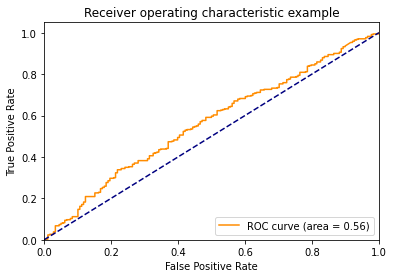

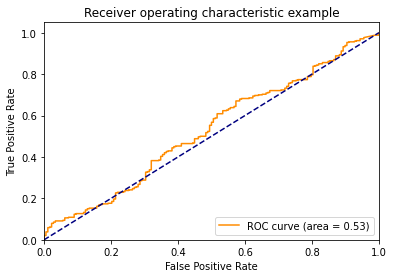

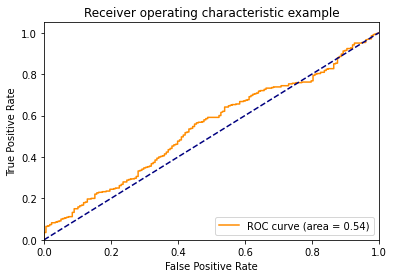

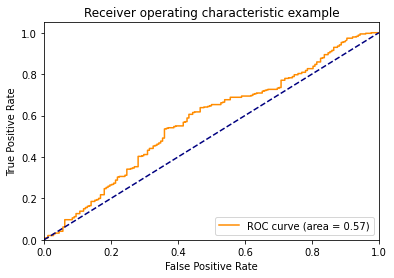

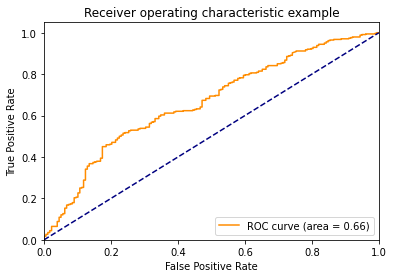

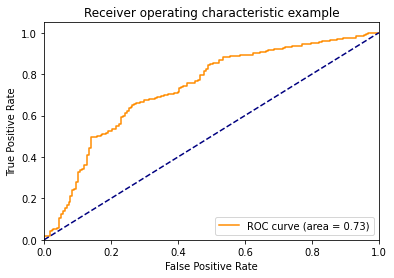

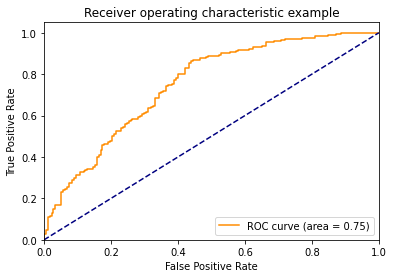

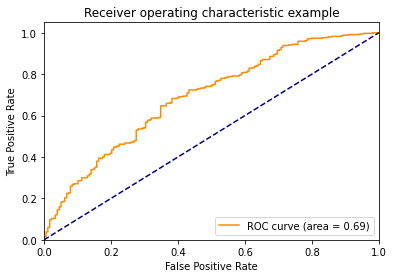

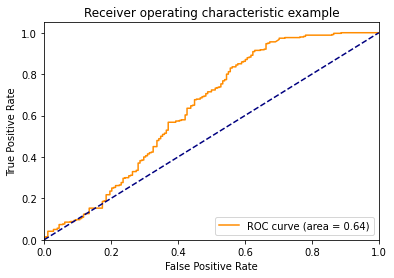

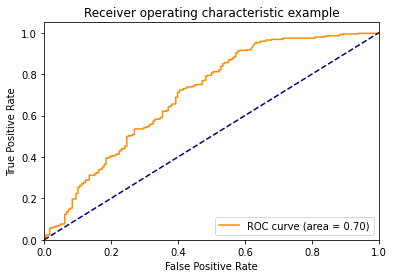

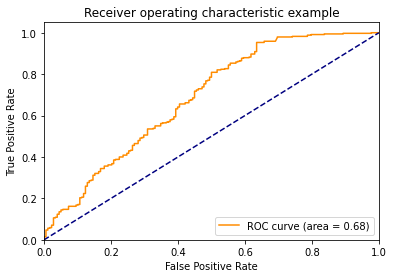

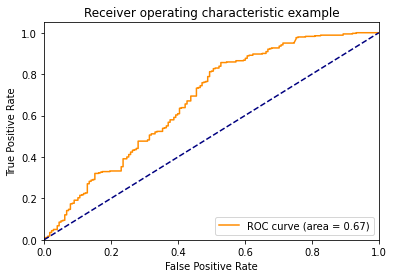

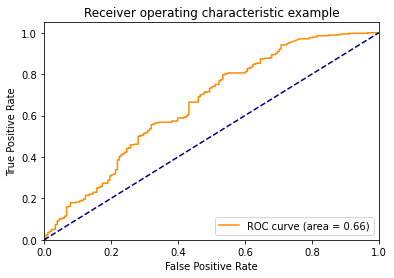

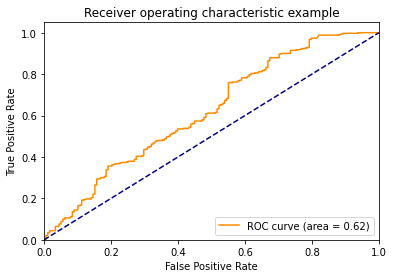

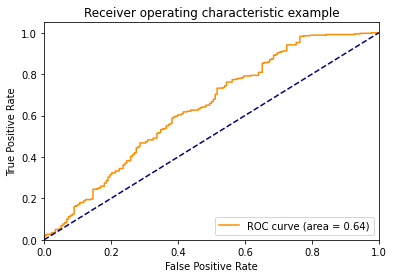

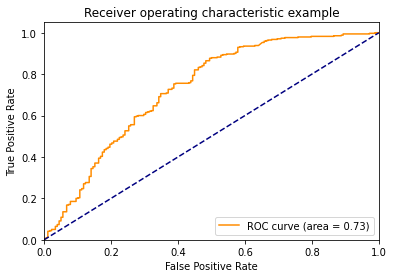

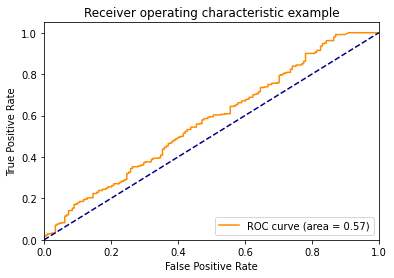

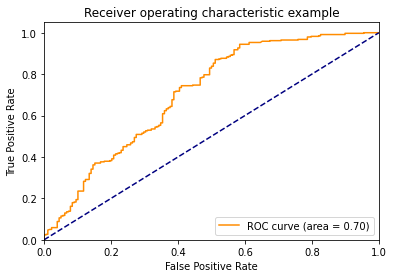

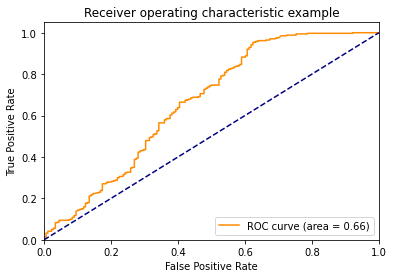

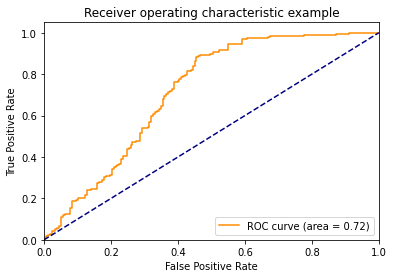

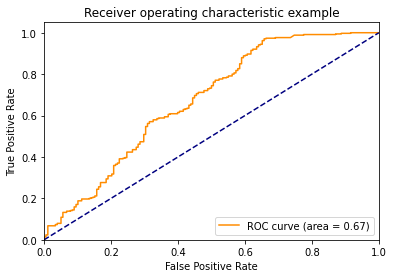

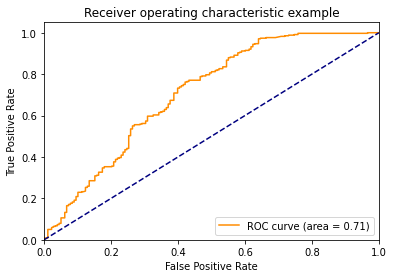

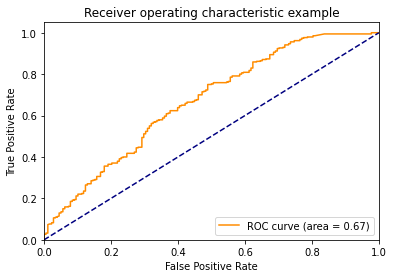

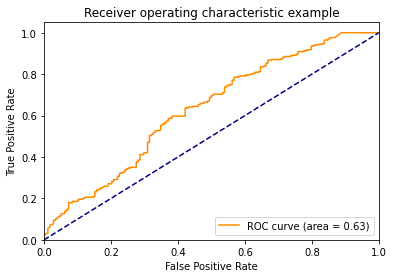

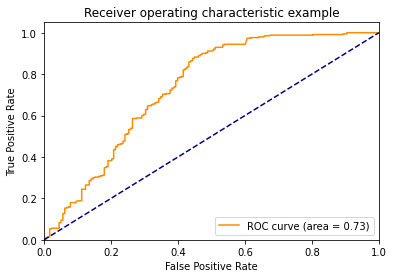

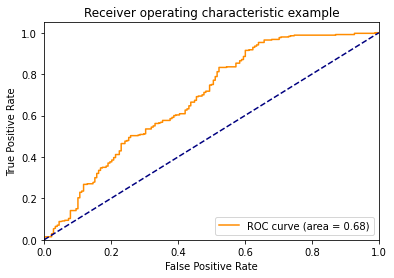

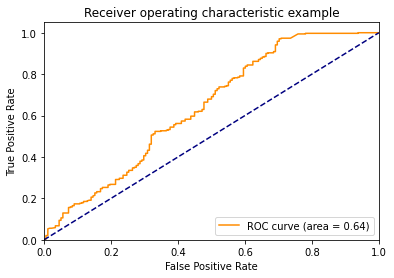

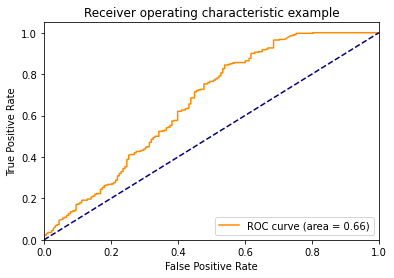

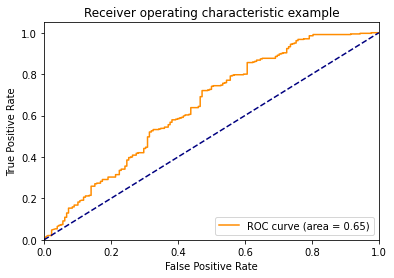

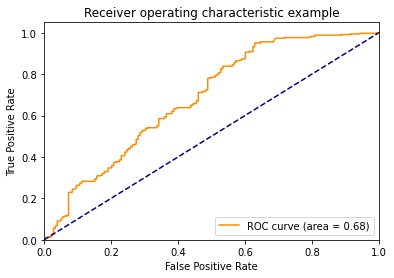

In [0]:
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []
epoch_val_losses = []
epoch_val_scores = []

for epoch in range(epochs):
    # train, test model
    train_losses, train_scores = train(log_interval, [cnn_encoder, rnn_decoder], device, train_loader, optimizer, epoch)
    epoch_val_loss, epoch_val_score, _ , _ = validation([cnn_encoder, rnn_decoder], device, optimizer, valid_loader , 'Validation')
    epoch_test_loss, epoch_test_score, prob , label = validation([cnn_encoder, rnn_decoder], device, optimizer, test_loader, 'Test')

        
    
    prob_cpu = prob.cpu()
    label_cpu = label.cpu()
    save_roc_curve(label_cpu, prob_cpu, epoch + 1)       

    # Reduce learning-rate by a factor of 1/10 after every 10 epochs
    # avoid this step as Adam is being used
    #adjust_learning_rate(optimizer=optimizer, learning_rate=learning_rate, epoch=epoch)
    
    # save results
    # writer_train.add_scalar('loss',train_losses,epoch+1)
    # writer_train.add_scalar('score',train_scores,epoch+1)
    # writer_val.add_scalar('loss',epoch_val_losses,epoch+1)
    # writer_val.add_scalar('score',epoch_val_scores,epoch+1)
    # writer_test.add_scalar('loss',epoch_test_loss,epoch+1)
    # writer_test.add_scalar('score',epoch_test_score,epoch+1)
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_val_losses.append(epoch_val_loss)
    epoch_val_scores.append(epoch_val_score)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)
    #Empty the cache
    torch.cuda.empty_cache()
# save_roc_curve(cat_labels, cat_probs)

Saving ROC Curve ...


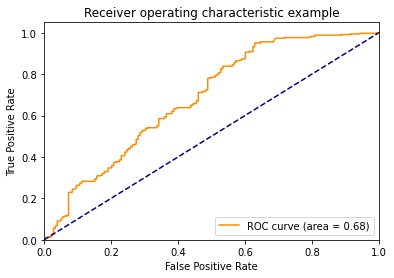

In [0]:
save_roc_curve(label_cpu, prob_cpu, epoch + 1)    

np.save('/content/drive/My Drive/ROB504/project/ROC_data/test_acc_'+ str(epoch + 1), np.array(epoch_test_scores))
np.save('/content/drive/My Drive/ROB504/project/ROC_data/test_loss_'+ str(epoch + 1), np.array(epoch_test_losses))
np.save('/content/drive/My Drive/ROB504/project/ROC_data/train_acc_'+ str(epoch + 1), np.array(train_scores))
np.save('/content/drive/My Drive/ROB504/project/ROC_data/train_loss_'+ str(epoch + 1), np.array(train_losses))